In [1]:
#Libraries
import os 
os.environ['DDE_BACKEND']='tensorflow'
import deepxde as dde
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image
from IPython.display import display

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
#PDE 
import sympy as sy
sy.init_printing(use_latex='mathjax')
C_L, mu_L,t,x,y,D_L,R,T=sy.symbols("C_l,mu_l,t,x,y,D_L,R,T")
mu_Lt=sy.Function('mu_L')(t)
mu_Lx=sy.Function('mu_L')(x)
mu_Ly=sy.Function('mu_L')(y)
C_Lx=sy.Function('C_L')(x)
C_Ly=sy.Function('C_L')(y)
LHS=C_L*sy.diff(mu_Lt,t)
RHS=(D_L/(R*T))*(sy.diff(C_Lx*sy.diff(mu_Lx,x),x)+sy.diff(C_Ly*sy.diff(mu_Ly,y),y))
chemical_equil=sy.Eq(LHS,RHS)
display(chemical_equil)

                    ⎛        2                    2                            ↪
                    ⎜       d                    d             d          d    ↪
                D_L⋅⎜C_L(x)⋅───(μ_L(x)) + C_L(y)⋅───(μ_L(y)) + ──(C_L(x))⋅──(μ ↪
                    ⎜         2                    2           dx         dx   ↪
   d                ⎝       dx                   dy                            ↪
Cₗ⋅──(μ_L(t)) = ────────────────────────────────────────────────────────────── ↪
   dt                                                        R⋅T               ↪

↪                               ⎞
↪          d          d         ⎟
↪ _L(x)) + ──(C_L(y))⋅──(μ_L(y))⎟
↪          dy         dy        ⎟
↪                               ⎠
↪ ───────────────────────────────
↪                                

In [2]:
#Domain
l=1
r=4e-3/6e-2
square=dde.geometry.Rectangle([0,0],[l,l])
circle=dde.geometry.Disk([0,0],r)
geom=dde.geometry.CSGDifference(square,circle)
time=dde.geometry.TimeDomain(0,1)
geomtime=dde.geometry.GeometryXTime(geom,time)


In [ ]:
#Case PDE-Chemical otential
def pde_mu(x,y):
    R=8.314
    T=298 
    D=3.8e-1
    mu = y[:,1:2]
    C  = y[:,0:1]
    C_ln = tf.math.log(C)
    dmudt=dde.grad.jacobian(mu,x,i=0,j=2)
    dmudx=dde.grad.jacobian(mu,x,i=0,j=0)
    dmudxx=dde.grad.hessian(mu,x,component=0,i=0,j=0)
    dmudy=dde.grad.jacobian(mu,x,i=0,j=1)
    dmudyy=dde.grad.hessian(mu,x,component=0,i=1,j=1)
    dcdx=dde.grad.jacobian(C,x,i=0,j=0)
    dcdy=dde.grad.jacobian(C,x,i=0,j=1)
    dlncdt=dde.grad.jacobian(C_ln,x,i=0,j=2)
    LHS=C*R*T*dlncdt
    RHS=(D/(R*T))*(C*dmudxx+C*dmudyy+dcdx*dmudx+dcdy*dmudy)
    return LHS-RHS


Compiling model...
'compile' took 0.001963 s

Training model...

Cause: could not parse the source code of <function <lambda> at 0x000001DA0B203880>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000001DA0B203880>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @

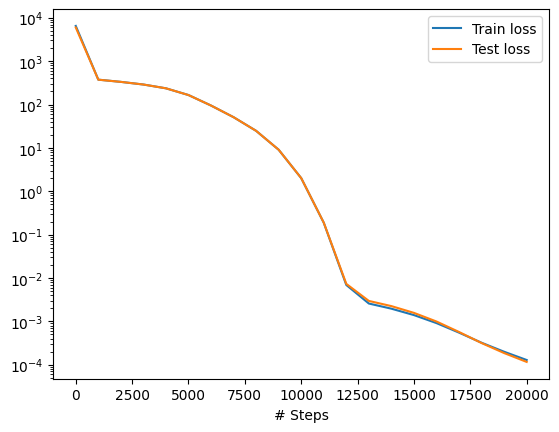

In [ ]:
#PINN structure-Chemical Potential
C_ic=dde.IC(geomtime, lambda x: 20, lambda x, on_initial: on_initial,component=0)
mu_ic=dde.IC(geomtime, lambda x: 0, lambda x, on_initial:on_initial,component=1) ####

data=dde.data.TimePDE(
    geomtime,
    pde_mu,
    [C_ic,mu_ic],
    num_domain=800,
    num_boundary=500,
    num_initial=800,
    num_test=800
)
layer=[3]+[64]*8+[2]
net=dde.maps.FNN(layer,"tanh","Glorot uniform")
model1=dde.Model(data,net)
model1.compile("adam",lr=0.0001)
losshistory, trainstate=model1.train(iterations=20000)
dde.saveplot(losshistory,trainstate,issave=True, isplot=True)



In [11]:
#Case PDE-Diffusion
def pde_C(x, y):
    D_L = 3.8e-1  # m^2/s
    V_H = 2e-6    # m^3/mole
    RT = 8.314 * 298  # J/mole
    Coe = (D_L * V_H) / RT
    C= y[:, 0:1]
    S=y[:,1:2]
    dC_dt = dde.grad.jacobian(C, x, i=0, j=2)
    CL_x = dde.grad.jacobian(C, x, i=0, j=0)
    CL_y = dde.grad.jacobian(C, x, i=0, j=1)
    CL_xx = dde.grad.hessian(C, x, component=0, i=0, j=0)
    CL_yy = dde.grad.hessian(C, x, component=0, i=1, j=1)
    sigma_t=dde.grad.jacobian(S,x,i=0,j=2)
    sigma_x = dde.grad.jacobian(S, x, i=0, j=0)
    sigma_y = dde.grad.jacobian(S, x, i=0, j=1)
    sigma_xx = dde.grad.hessian(S, x, component=0, i=0, j=0)
    sigma_yy = dde.grad.hessian(S, x, component=0, i=1, j=1)
    eq1 = (dC_dt- D_L* (CL_xx + CL_yy)+ Coe * (CL_x * sigma_x+ CL_y * sigma_y+ C * (sigma_xx + sigma_yy)))
    eq2=sigma_t
    return [eq1,eq2]

Compiling model...
'compile' took 0.003524 s

Training model...

Cause: could not parse the source code of <function <lambda> at 0x000001DA1C84E200>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000001DA1C84E200>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @

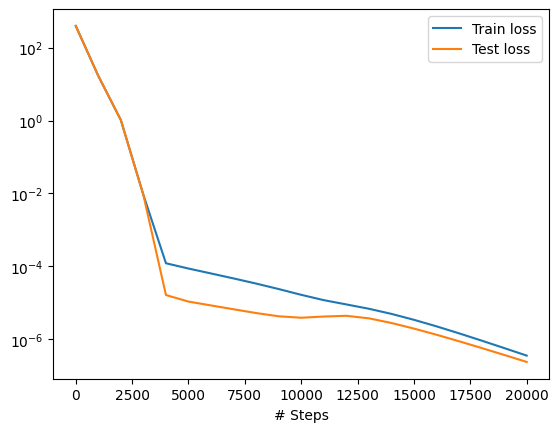

In [ ]:
#PINN structure-Diffusion
C_ic=dde.IC(geomtime, lambda x: 20, lambda x, on_initial: on_initial,component=0)

data=dde.data.TimePDE(
    geomtime,
    pde_C,
    [C_ic],
    num_domain=800,
    num_boundary=500,
    num_initial=800,
    num_test=800
)
layer=[3]+[64]*8+[2]
net=dde.maps.FNN(layer,"tanh","Glorot uniform")
model2=dde.Model(data,net)
model2.compile("adam",lr=0.0001)
losshistory, trainstate=model2.train(iterations=20000)
dde.saveplot(losshistory,trainstate,issave=True, isplot=True)




MovieWriter imagemagick unavailable; using Pillow instead.


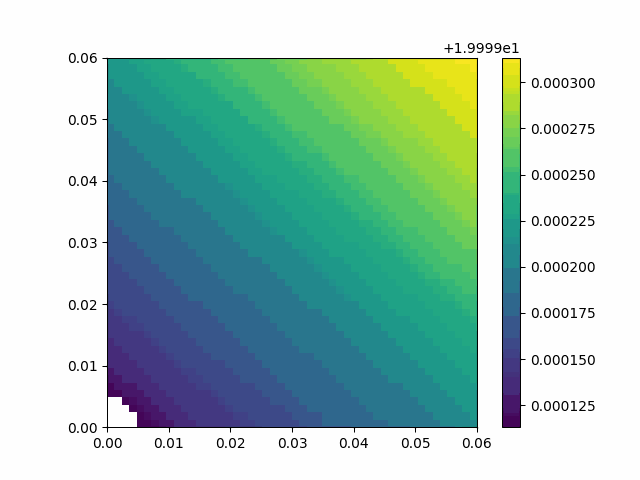

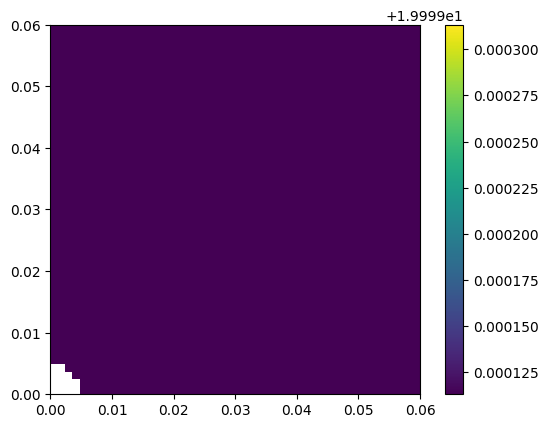

In [15]:
#Plot
length=6e-2
resolution =50
radius = 4e-3
time=1
t= np.linspace(0, time, resolution)
x = np.linspace(0, length, resolution)
y = np.linspace(0, length, resolution)
data = np.zeros((resolution,resolution, resolution))
# Generate frames for each time step
for h in range(resolution):
    for i in range(resolution):
        for j in range(resolution):
            # Pass individual x, y, t values to model.predict()
             prediction= model2.predict([[x[i], y[j], t[h]]])[0][0]
             data[i, j , h]=prediction
             if (x[i]**2 + y[j]**2) < radius**2:
                 data[i,j,h]=None
    # Apply mask for the central hole
    

    
# Initialize the plot
fig, ax = plt.subplots()
contour = ax.imshow(data[:,:,0], extent=[0, length, 0, length], origin="lower", cmap="viridis")
fig.colorbar(contour)

# Update function for each frame
def update(frame):
    contour.set_data(data[:,:,frame])
    return [contour]

# Create the animation
anim = FuncAnimation(fig, update, frames=resolution, interval=500, blit=True)
anim.save("animation.gif", writer="imagemagick")
# Display the animation
display(Image(filename="animation.gif"))